<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#一、-数据" data-toc-modified-id="一、-数据-1">一、 数据</a></span></li><li><span><a href="#二.、通用函数" data-toc-modified-id="二.、通用函数-2">二.、通用函数</a></span><ul class="toc-item"><li><span><a href="#1.-数据处理" data-toc-modified-id="1.-数据处理-2.1">1. 数据处理</a></span></li><li><span><a href="#2.-评价指标" data-toc-modified-id="2.-评价指标-2.2">2. 评价指标</a></span></li></ul></li><li><span><a href="#三.-算法实现" data-toc-modified-id="三.-算法实现-3">三. 算法实现</a></span><ul class="toc-item"><li><span><a href="#1.-MostPopular" data-toc-modified-id="1.-MostPopular-3.1">1. MostPopular</a></span></li><li><span><a href="#2.-GenderMostPopular" data-toc-modified-id="2.-GenderMostPopular-3.2">2. GenderMostPopular</a></span></li><li><span><a href="#3.-AgeMostPopular" data-toc-modified-id="3.-AgeMostPopular-3.3">3. AgeMostPopular</a></span></li><li><span><a href="#4.-CountryMostPopular" data-toc-modified-id="4.-CountryMostPopular-3.4">4. CountryMostPopular</a></span></li><li><span><a href="#5.-DemographicMostPopular" data-toc-modified-id="5.-DemographicMostPopular-3.5">5. DemographicMostPopular</a></span></li></ul></li><li><span><a href="#四、实验" data-toc-modified-id="四、实验-4">四、实验</a></span><ul class="toc-item"><li><span><a href="#1.-MostPopular" data-toc-modified-id="1.-MostPopular-4.1">1. MostPopular</a></span></li><li><span><a href="#2.-GenderMostPopular" data-toc-modified-id="2.-GenderMostPopular-4.2">2. GenderMostPopular</a></span></li><li><span><a href="#3.-AgeMostPopular" data-toc-modified-id="3.-AgeMostPopular-4.3">3. AgeMostPopular</a></span></li><li><span><a href="#4.-CountryMostPopular" data-toc-modified-id="4.-CountryMostPopular-4.4">4. CountryMostPopular</a></span></li><li><span><a href="#5.-DemographicMostPopular" data-toc-modified-id="5.-DemographicMostPopular-4.5">5. DemographicMostPopular</a></span></li></ul></li></ul></div>

# 用户冷启动-利用用户注册信息

In [1]:
# 导入包
import random
import math
import time

## 一、 数据

本实验使用Last.fm 360K 数据集，它包含了36万users对30万artists的收听情况，文件大小1.6G，共17559530行记录。

下载链接：http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-360K.tar.gz

将下载好的数据压缩包解压至dataset文件夹中。

## 二.、通用函数

In [2]:
# 定义装饰器，监控运行时间
# 装饰器详解：https://www.cnblogs.com/yuzhanhong/p/9180212.html；简单来讲就是对其他函数进行计时功能的扩展
def timmer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        res = func(*args, **kwargs)
        stop_time = time.time()
        print('Func %s, run time: %s' % (func.__name__, stop_time - start_time))
        return res
    return wrapper

### 1. 数据处理

up = './dataset/lastfm-dataset-360K/usersha1-profile.tsv'

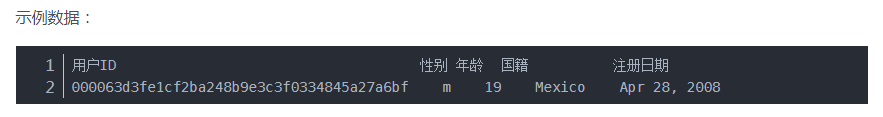

fp='./dataset/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'

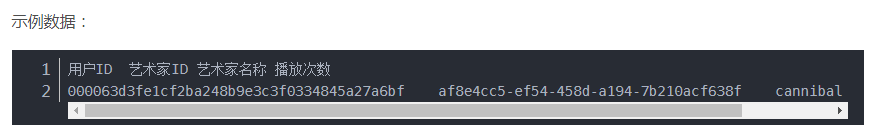

In [3]:
class Dataset():
    
    def __init__(self, fp, up):
        # fp: data file path ，示例数据见上文
        # up: user profile path ，示例数据见上文
        self.data, self.profile = self.loadData(fp, up)
    
    @timmer
    def loadData(self, fp, up):
        # 使用列表存储用户行为数据
        data = []
        for l in open(fp,encoding="utf-8"):
            # 文件中每一行字符串先去掉首尾空白符，然后用“\t”拆分，最后取前两个元素（用户ID和艺术家ID）存入data
            data.append(tuple(l.strip().split('\t')[:2]))
        
        # 使用字典存储用户属性数据
        profile = {}
        for l in open(up,encoding="utf-8"):
            # 同上文，字符串拆分并取相应值
            user, gender, age, country, _ = l.strip().split('\t')
            # age 缺省值填充-1
            if age == '': 
                age = -1
            # 使用字典存储每个用户的属性信息
            profile[user] = {'gender': gender, 'age': int(age), 'country': country}
            
        ####################### 按照用户进行采样
        # 取所有用户ID的列表
        users = list(profile.keys()) 
        # 将所有用户随机排序
        random.shuffle(users) 
        # 取前5000个用户并去重
        users = set(users[:5000])
        # 根据采样后的用户ID从data中取相应的行为数据
        data = [x for x in data if x[0] in users]  # Python 列表推导式详解 https://www.runoob.com/note/15802
        # 据采样后的用户ID筛选相应的属性数据
        profile = {k: profile[k] for k in users} # 与列表推导式同理
        # 返回采样后的数据
        return data, profile
    
    @timmer
    def splitData(self, M, k, seed=1):
        '''
        :params: M, 划分的数目，最后需要取M折的平均
        :params: k, 本次是第几次划分，k~[0, M)
        :params: seed, random的种子数，对于不同的k应设置成一样的
        '''
        # 列表存储训练集和测试集
        train, test = [], []
        # 设置相同的seed，每次下面生成的随机数相同。如果不设置seed，则每次会生成不同的随机数
        random.seed(seed) # https://www.runoob.com/python/func-number-seed.html
        for user, item in self.data:
            # random.randint取[0,M-1]闭区间上的整数
            if random.randint(0, M-1) == k:  
                # 一份测试集
                test.append((user, item))
            else:
                # 其他作为训练集
                train.append((user, item))

        # 行为数据处理成字典的形式：user->set(items)
        def convert_dict(data):
            data_dict = {}
            for user, item in data:
                # 初始化该用户的行为记录为一个集合
                if user not in data_dict:
                    data_dict[user] = set()
                # 字典赋值：循环结束后既可以收集到该用户全部有行为的item
                data_dict[user].add(item)
            # 将字典的值转换为列表格式存储
            data_dict = {k: list(data_dict[k]) for k in data_dict}
            return data_dict

        return convert_dict(train), convert_dict(test), self.profile

### 2. 评价指标

准确率、召回率、覆盖率

In [4]:
class Metric():
    
    def __init__(self, train, test, GetRecommendation):
        '''
        :params: train, 训练数据
        :params: test, 测试数据
        :params: GetRecommendation, 为某个用户获取推荐物品的接口函数
        '''
        self.train = train
        self.test = test
        self.GetRecommendation = GetRecommendation
        self.recs = self.getRec()
        
    # 为test中的每个用户进行推荐
    def getRec(self):
        # 字典存储所有用户的推荐结果
        recs = {}
        for user in self.test:
            # 获取每个用户的推荐列表
            rank = self.GetRecommendation(user)
            # 字典赋值
            recs[user] = rank
        return recs
        
    # 定义精确率指标计算方式
    # 准确率是推荐结果中命中的比例 
    def precision(self):
        # all 是为所有测试用户推荐的总item数目 ，hit 是命中数目
        all, hit = 0, 0
        # 遍历每个用户
        for user in self.test:
            # 每个用户的物品集合
            test_items = set(self.test[user])
            # 取该用户的推荐结果
            rank = self.recs[user]
            # 遍历累加推荐结果中命中测试集的个数
            for item, score in rank:
                # 推荐结果命中测试集item
                if item in test_items:
                    hit += 1
            # all 是所有测试用户的推荐数目累加和
            all += len(rank)
        # 返回精确率
        return round(hit / all * 100, 2)  # round()方法 https://www.runoob.com/python/func-number-round.html
    
    # 定义召回率指标计算方式
    # 召回率是测试集中命中的比例，相比精确率只有all的取值不同
    def recall(self):
        all, hit = 0, 0
        for user in self.test:
            test_items = set(self.test[user])
            rank = self.recs[user]
            for item, score in rank:
                if item in test_items:
                    hit += 1
            all += len(test_items)
        return round(hit / all * 100, 2)
    
    # 定义覆盖率指标计算方式
    # 覆盖率是推荐的items数量占总物品集合的1比例，故有如下代码
    def coverage(self):
        all_item, recom_item = set(), set()
        for user in self.test:
            if user in self.train:
                for item in self.train[user]:
                    all_item.add(item)
            rank = self.recs[user]
            for item, score in rank:
                recom_item.add(item)
        return round(len(recom_item) / len(all_item) * 100, 2)
    
    # 打包所有指标
    def eval(self):
        metric = {'Precision': self.precision(),
                  'Recall': self.recall(),
                  'Coverage': self.coverage()}
        print('Metric:', metric)
        return metric

## 三. 算法实现

### 1. MostPopular

In [5]:
def MostPopular(train, profile, N):
    '''
    :params: train, 训练数据
    :params: profile, 用户的注册信息
    :params: N, 推荐TopN物品的个数
    :return: GetRecommendation, 获取推荐结果的接口
    '''
    # 字典存储每个item的数量
    items = {}
    # 遍历取行为数据中所有item
    for user in train:
        for item in train[user]:
            # 字典初始化
            if item not in items:
                items[item] = 0
            # 累加每个item的数量
            items[item] += 1
    # 根据item的数量进行降序排序并转换为列表存入items中
    # sorted的参数key指定了排序的依据，默认升序，reverse=True表示反转：降序
    items = list(sorted(items.items(), key=lambda x: x[1], reverse=True))
        
    # 获取接口函数
    def GetRecommendation(user):
        # 看过的item集合，新用户（不在train中）则返回空集
        seen_items = set(train[user]) if user in train else set()
        # 给老用户推荐没看过的items中收听量前N的item;新用户则直接推荐热度topN的item
        recs = [x for x in items if x[0] not in seen_items][:N]
        return recs
    
    # 返回函数引用
    return GetRecommendation

### 2. GenderMostPopular

In [6]:
def GenderMostPopular(train, profile, N):
    '''
    :params: train, 训练数据
    :params: profile, 用户的注册信息
    :params: N, 推荐TopN物品的个数
    :return: GetRecommendation, 获取推荐结果的接口
    '''
    # 相比MostPopula只是分男女统计每个item数量
    mitems, fitems = {}, {} # 男、女
    for user in train:
        if profile[user]['gender'] == 'm':
            tmp = mitems
        elif profile[user]['gender'] == 'f':
            tmp = fitems
        for item in train[user]:
            if item not in tmp:
                tmp[item] = 0
            # tmp 的变化直接改变对应 mitems或fitems 的值 （一个用户只要一个性别属性，即一次循环tmp只改变mitems或fitems中的一个）
            tmp[item] += 1
            
    # 分性别topN排序
    mitems = list(sorted(mitems.items(), key=lambda x: x[1], reverse=True))
    fitems = list(sorted(fitems.items(), key=lambda x: x[1], reverse=True))
    # 不分性别topN排序
    mostPopular = MostPopular(train, profile, N)
    
    # 获取接口函数
    def GetRecommendation(user):
        seen_items = set(train[user]) if user in train else set()
        if profile[user]['gender'] == 'm':
            recs = [x for x in mitems if x[0] not in seen_items][:N]
        elif profile[user]['gender'] == 'f':
            recs = [x for x in fitems if x[0] not in seen_items][:N]
        else: # 没有提供性别信息的，按照MostPopular推荐
            recs = mostPopular(user)
        return recs
    
    return GetRecommendation

### 3. AgeMostPopular

In [7]:
# 参考上文思路，代码只是做了分年龄的热度统计
def AgeMostPopular(train, profile, N):
    '''
    :params: train, 训练数据
    :params: profile, 用户的注册信息
    :params: N, 推荐TopN物品的个数
    :return: GetRecommendation, 获取推荐结果的接口
    '''
    
    # 对年龄进行分段
    ages = []
    for user in profile:
        if profile[user]['age'] >= 0:
            ages.append(profile[user]['age'])
    maxAge, minAge = max(ages), min(ages)
    items = [{} for _ in range(int(maxAge // 10 + 1))]
    
    # 分年龄段进行统计
    for user in train:
        if profile[user]['age'] >= 0:
            age = profile[user]['age'] // 10
            for item in train[user]:
                if item not in items[age]:
                    items[age][item] = 0
                items[age][item] += 1
    for i in range(len(items)):
        items[i] = list(sorted(items[i].items(), key=lambda x: x[1], reverse=True))
    
    mostPopular = MostPopular(train, profile, N)
    
    # 获取接口函数
    def GetRecommendation(user):
        seen_items = set(train[user]) if user in train else set()
        if profile[user]['age'] >= 0:
            age = profile[user]['age'] // 10
            # 年龄信息异常的，按照全局推荐
            if age >= len(items) or len(items[age]) == 0:
                recs = mostPopular(user)
            else:
                recs = [x for x in items[age] if x[0] not in seen_items][:N]
        else: # 没有提供年龄信息的，按照全局推荐
            recs = mostPopular(user)
        return recs
    
    return GetRecommendation

### 4. CountryMostPopular

In [8]:
# 参考上文思路，代码只是做了分城市的热度统计
def CountryMostPopular(train, profile, N):
    '''
    :params: train, 训练数据
    :params: profile, 用户的注册信息
    :params: N, 推荐TopN物品的个数
    :return: GetRecommendation, 获取推荐结果的接口
    '''
        
    # 分城市进行统计
    items = {}
    for user in train:
        country = profile[user]['country']
        if country not in items:
            items[country] = {}
        for item in train[user]:
            if item not in items[country]:
                items[country][item] = 0
            items[country][item] += 1
    for country in items:
        items[country] = list(sorted(items[country].items(), key=lambda x: x[1], reverse=True))
    
    mostPopular = MostPopular(train, profile, N)
    
    # 获取接口函数
    def GetRecommendation(user):
        seen_items = set(train[user]) if user in train else set()
        country = profile[user]['country']
        if country in items:
            recs = [x for x in items[country] if x[0] not in seen_items][:N]
        else: # 没有提供城市信息的，按照全局推荐
            recs = mostPopular(user)
        return recs
    
    return GetRecommendation

### 5. DemographicMostPopular

In [9]:
# 综合当前用户的注册信息进行推荐
def DemographicMostPopular(train, profile, N):
    '''
    :params: train, 训练数据
    :params: profile, 用户的注册信息
    :params: N, 推荐TopN物品的个数
    :return: GetRecommendation, 获取推荐结果的接口
    '''

    # 建立多重字典，将缺失值当成other，同归为一类进行处理
    items = {}
    for user in train:
        gender = profile[user]['gender']
        if gender not in items:
            items[gender] = {}
        age = profile[user]['age'] // 10
        if age not in items[gender]:
            items[gender][age] = {}
        country = profile[user]['country']
        if country not in items[gender][age]:
            items[gender][age][country] = {}
        for item in train[user]:
            if item not in items[gender][age][country]:
                items[gender][age][country][item] = 0
            items[gender][age][country][item] += 1
    for gender in items:
        for age in items[gender]:
            for country in items[gender][age]:
                items[gender][age][country] = list(sorted(items[gender][age][country].items(), 
                                                          key=lambda x: x[1], reverse=True))
                
    mostPopular = MostPopular(train, profile, N)
    
    # 获取接口函数
    def GetRecommendation(user):
        seen_items = set(train[user]) if user in train else set()
        gender = profile[user]['gender']
        age = profile[user]['age']
        country = profile[user]['country']
        if gender not in items or age not in items[gender] or country not in items[gender][age]:
            recs = mostPopular(user)
        else:
            recs = [x for x in items[gender][age][country] if x[0] not in seen_items][:N]
        return recs
    
    return GetRecommendation

## 四、实验

In [10]:
class Experiment():
    
    def __init__(self, M, N, at='MostPopular',
                 fp='./dataset/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv',
                 up='./dataset/lastfm-dataset-360K/usersha1-profile.tsv'):
        '''
        :params: M, 进行多少次实验
        :params: N, TopN推荐物品的个数
        :params: at, 使用的算法名
        :params: fp, 数据文件路径
        :params: up, 用户注册信息文件路径
        '''
        self.M = M
        self.N = N
        self.fp = fp
        self.up = up
        self.at = at
        # 定义at参数对应的函数名
        self.alg = {'MostPopular': MostPopular, 'GenderMostPopular': GenderMostPopular,
                    'AgeMostPopular': AgeMostPopular, 'CountryMostPopular': CountryMostPopular,
                    'DemographicMostPopular': DemographicMostPopular}
    
    # 定义单次实验
    @timmer
    def worker(self, train, test, profile):
        '''
        :params: train, 训练数据集
        :params: test, 测试数据集
        :params: profile, 用户注册信息
        :return: 各指标的值
        '''
        # 调用指定的推荐算法
        getRecommendation = self.alg[self.at](train, profile, self.N)
        # 调用评价函数
        metric = Metric(train, test, getRecommendation)
        # 返回评价指标
        return metric.eval()
    
    # M次实验取平均
    @timmer
    def run(self):
        metrics = {'Precision': 0, 'Recall': 0, 
                   'Coverage': 0}
        
        # 初始化一个数据对象，具体可参看Dataset类
        dataset = Dataset(self.fp, self.up)
        for ii in range(self.M):
            # 划分数据集
            train, test, profile = dataset.splitData(self.M, ii)
            # 第几次实验
            print('Experiment {}:'.format(ii))
            # 当前实验的评价指标
            metric = self.worker(train, test, profile)
            # 累加当前实验的每个指标 metric[k] ，结果存在 metrics 中
            metrics = {k: metrics[k]+metric[k] for k in metrics}
        # 计算每个指标的平均值
        metrics = {k: metrics[k] / self.M for k in metrics}
        # 输出结果
        print('Average Result (M={}, N={}): {}'.format(\
                              self.M, self.N, metrics))

### 1. MostPopular

In [11]:
# M次试验，推荐topN
M, N = 10, 10
exp = Experiment(M, N, at='MostPopular')
exp.run()

Func loadData, run time: 70.38202571868896
Func splitData, run time: 0.7500429153442383
Experiment 0:
Metric: {'Precision': 2.3, 'Recall': 4.68, 'Coverage': 0.07}
Func worker, run time: 36.15706825256348
Func splitData, run time: 0.6500372886657715
Experiment 1:
Metric: {'Precision': 2.24, 'Recall': 4.55, 'Coverage': 0.07}
Func worker, run time: 38.96022820472717
Func splitData, run time: 0.7690439224243164
Experiment 2:
Metric: {'Precision': 2.16, 'Recall': 4.37, 'Coverage': 0.07}
Func worker, run time: 45.32559251785278
Func splitData, run time: 0.7970454692840576
Experiment 3:
Metric: {'Precision': 2.27, 'Recall': 4.59, 'Coverage': 0.07}
Func worker, run time: 43.01646041870117
Func splitData, run time: 0.952054500579834
Experiment 4:
Metric: {'Precision': 2.36, 'Recall': 4.82, 'Coverage': 0.07}
Func worker, run time: 51.1019229888916
Func splitData, run time: 0.8530488014221191
Experiment 5:
Metric: {'Precision': 2.28, 'Recall': 4.67, 'Coverage': 0.07}
Func worker, run time: 38.887

### 2. GenderMostPopular

In [14]:
M, N = 10, 10
exp = Experiment(M, N, at='GenderMostPopular')
exp.run()

Func loadData, run time: 53.76307511329651
Func splitData, run time: 0.7260417938232422
Experiment 0:
Metric: {'Precision': 2.39, 'Recall': 4.87, 'Coverage': 0.1}
Func worker, run time: 27.024545907974243
Func splitData, run time: 0.6180355548858643
Experiment 1:
Metric: {'Precision': 2.26, 'Recall': 4.58, 'Coverage': 0.1}
Func worker, run time: 27.49257254600525
Func splitData, run time: 0.605034351348877
Experiment 2:
Metric: {'Precision': 2.35, 'Recall': 4.76, 'Coverage': 0.1}
Func worker, run time: 31.577805995941162
Func splitData, run time: 0.6250357627868652
Experiment 3:
Metric: {'Precision': 2.34, 'Recall': 4.75, 'Coverage': 0.11}
Func worker, run time: 29.67869758605957
Func splitData, run time: 0.7860450744628906
Experiment 4:
Metric: {'Precision': 2.3, 'Recall': 4.72, 'Coverage': 0.11}
Func worker, run time: 34.32196307182312
Func splitData, run time: 0.602034330368042
Experiment 5:
Metric: {'Precision': 2.34, 'Recall': 4.8, 'Coverage': 0.1}
Func worker, run time: 28.758645

### 3. AgeMostPopular

In [15]:
M, N = 10, 10
exp = Experiment(M, N, at='AgeMostPopular')
exp.run()

Func loadData, run time: 47.0456907749176
Func splitData, run time: 0.6710383892059326
Experiment 0:
Metric: {'Precision': 2.45, 'Recall': 4.98, 'Coverage': 0.49}
Func worker, run time: 22.68529748916626
Func splitData, run time: 0.6670382022857666
Experiment 1:
Metric: {'Precision': 2.22, 'Recall': 4.47, 'Coverage': 0.49}
Func worker, run time: 22.506287336349487
Func splitData, run time: 0.6180355548858643
Experiment 2:
Metric: {'Precision': 2.35, 'Recall': 4.75, 'Coverage': 0.48}
Func worker, run time: 21.3142192363739
Func splitData, run time: 0.6870396137237549
Experiment 3:
Metric: {'Precision': 2.46, 'Recall': 4.96, 'Coverage': 0.48}
Func worker, run time: 20.960198640823364
Func splitData, run time: 0.6770386695861816
Experiment 4:
Metric: {'Precision': 2.33, 'Recall': 4.74, 'Coverage': 0.47}
Func worker, run time: 21.495229721069336
Func splitData, run time: 0.6210355758666992
Experiment 5:
Metric: {'Precision': 2.35, 'Recall': 4.8, 'Coverage': 0.47}
Func worker, run time: 20.

### 4. CountryMostPopular

In [16]:
M, N = 10, 10
exp = Experiment(M, N, at='CountryMostPopular')
exp.run()

Func loadData, run time: 97.45357394218445
Func splitData, run time: 1.8221039772033691
Experiment 0:
Metric: {'Precision': 2.4, 'Recall': 4.85, 'Coverage': 2.59}
Func worker, run time: 6.109349489212036
Func splitData, run time: 0.6920394897460938
Experiment 1:
Metric: {'Precision': 2.36, 'Recall': 4.74, 'Coverage': 2.58}
Func worker, run time: 4.733270645141602
Func splitData, run time: 0.6970396041870117
Experiment 2:
Metric: {'Precision': 2.41, 'Recall': 4.82, 'Coverage': 2.62}
Func worker, run time: 4.655266284942627
Func splitData, run time: 0.6400365829467773
Experiment 3:
Metric: {'Precision': 2.45, 'Recall': 4.9, 'Coverage': 2.61}
Func worker, run time: 4.7202699184417725
Func splitData, run time: 0.7340419292449951
Experiment 4:
Metric: {'Precision': 2.37, 'Recall': 4.79, 'Coverage': 2.61}
Func worker, run time: 4.662266492843628
Func splitData, run time: 0.6950395107269287
Experiment 5:
Metric: {'Precision': 2.52, 'Recall': 5.1, 'Coverage': 2.61}
Func worker, run time: 4.864

### 5. DemographicMostPopular

In [17]:
M, N = 10, 10
exp = Experiment(M, N, at='DemographicMostPopular')
exp.run()

Func loadData, run time: 71.61909627914429
Func splitData, run time: 0.8030459880828857
Experiment 0:
Metric: {'Precision': 2.25, 'Recall': 4.52, 'Coverage': 3.32}
Func worker, run time: 28.923654556274414
Func splitData, run time: 0.6320362091064453
Experiment 1:
Metric: {'Precision': 2.24, 'Recall': 4.49, 'Coverage': 3.34}
Func worker, run time: 31.717813968658447
Func splitData, run time: 0.7390422821044922
Experiment 2:
Metric: {'Precision': 2.33, 'Recall': 4.64, 'Coverage': 3.25}
Func worker, run time: 35.08500695228577
Func splitData, run time: 0.6840391159057617
Experiment 3:
Metric: {'Precision': 2.21, 'Recall': 4.42, 'Coverage': 3.27}
Func worker, run time: 31.2217857837677
Func splitData, run time: 0.6820390224456787
Experiment 4:
Metric: {'Precision': 2.18, 'Recall': 4.39, 'Coverage': 3.31}
Func worker, run time: 34.09795069694519
Func splitData, run time: 0.6100349426269531
Experiment 5:
Metric: {'Precision': 2.14, 'Recall': 4.33, 'Coverage': 3.27}
Func worker, run time: 33